In [2]:
import sounddevice as sd
import time
import matplotlib.pyplot as plt
from pylab import *
#Parameters--------------
fs = 48*10**3 #48k

#------------------------
sd.default.samplerate = fs
sd.default.channels = 1

n=41
saveToFile = True

duration=20
myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=1)

#error https://github.com/spatialaudio/python-sounddevice/issues/74
#get the /usr/lib/x86_64-linux-gnu/libportaudio.so.2 to /home/aadc/anaconda3/lib/libportaudio.so
#because it was broken

In [3]:
#sd.RawInputStream(samplerate=44*10**3,)
#n-=1
from sklearn.externals import joblib
clf = joblib.load('alarm_lr_clf.pkl')
clf2 = joblib.load('alarm_lr_clf2.pkl')

In [283]:
n=n-1

In [289]:
# record something
sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
time.sleep(duration)

if saveToFile:
    fn = 'rec_{}_label_{}_.np.npy'.format(n,0) #SET LABEL HERE #IMPORTANT!!! #.np for training, testing for testing
    np.save(fn,sig)
    n+=1

In [4]:
#open all recordings
import glob
fns = glob.glob("*test.npy")
sigs = []
ys = []
for fn in fns:
    sigs.append( np.load(fn).flatten() )
    ys.append(fn.split('_')[3])

In [174]:
def mySpec(sig,fs,nfft):
    l = range(0,len(sig)-len(sig)%nfft,nfft)
    a = np.zeros((nfft//2,len(l)))
    #sig = sig-sig.mean()
    for si, s in enumerate(l):
        ss = sig[s:s+nfft].flatten()
        a[:,si] = (np.abs(np.fft.fft(ss))/nfft)[:nfft//2] #flatten!!! otherwise it will be done over rows =SSSS
        # fuck that cost me some time =S
    freqs = np.linspace(0,fs/2,(nfft/2))
    t = np.linspace(0,(len(sig)-len(sig)%nfft)/fs,len(l))
    return a, freqs, t
    #plt.imshow((np.log(a)))

/home/aadc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


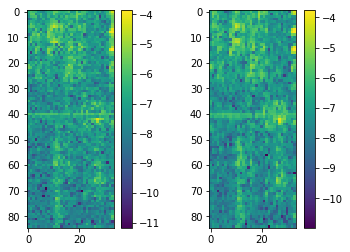

In [177]:
nfft = 2**11
spect, frs,ts = mySpec(sig,fs,nfft)
plt.subplot(1,2,1)
plt.imshow(np.log( spect[((frs>1000) * (frs<3000))]))
plt.colorbar()
plt.subplot(1,2,2)
spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=nfft,scale='dB',noverlap=0,mode='magnitude',pad_to=None);
plt.imshow(np.log( spectrum[(freqs>1000)*(freqs<3000)] ))
plt.colorbar()
#difference is that specgram uses a hanning-window

In [113]:
spect.shape, spectrum.shape

((1024, 34), (1025, 34))

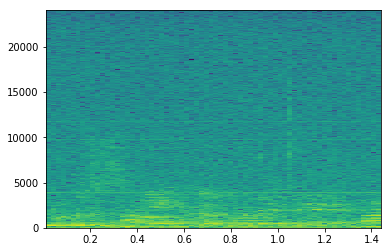

In [59]:
spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=1040);

CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 30.2 ms
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.25 ms


array([[3.97220254e-03, 2.00390816e-03, 2.13578343e-03, ...,
        8.97523761e-03, 1.19017661e-02, 1.01034343e-02],
       [4.78729960e-03, 8.06722443e-03, 3.97892246e-03, ...,
        5.15855757e-03, 6.32253698e-03, 2.05467150e-03],
       [4.61234946e-03, 6.45626983e-03, 3.12224423e-03, ...,
        4.68451011e-03, 6.62299413e-03, 9.50125480e-03],
       ...,
       [1.13688033e-04, 5.24086009e-05, 7.88403250e-05, ...,
        8.47741964e-05, 1.14916207e-04, 5.47710092e-06],
       [4.08328860e-05, 2.30816665e-05, 4.62040145e-05, ...,
        1.06024717e-05, 4.15708859e-05, 1.03469292e-04],
       [1.06366373e-04, 1.23062474e-04, 9.94441170e-05, ...,
        9.37830180e-05, 5.83908352e-05, 4.15031535e-05]])

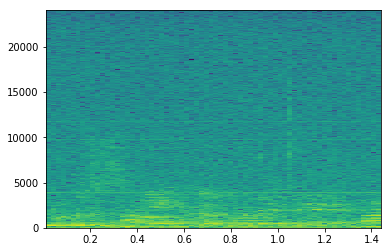

In [44]:
%time spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=1040);
%time mySpec(sig) 

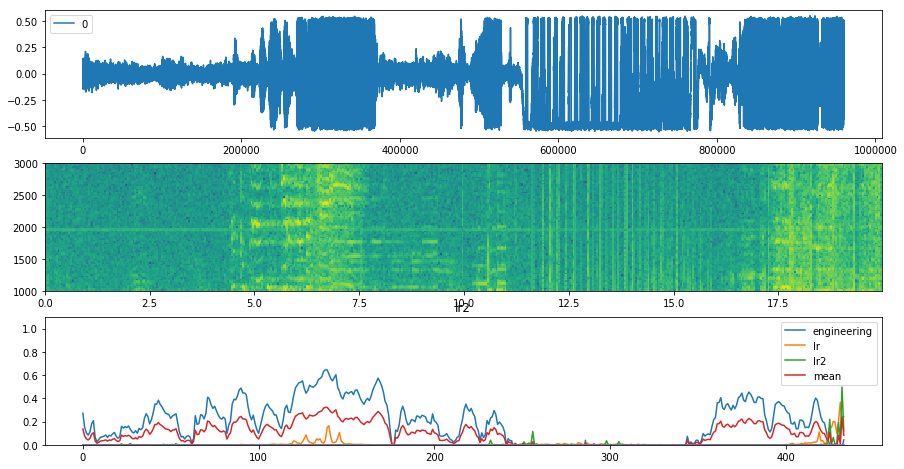

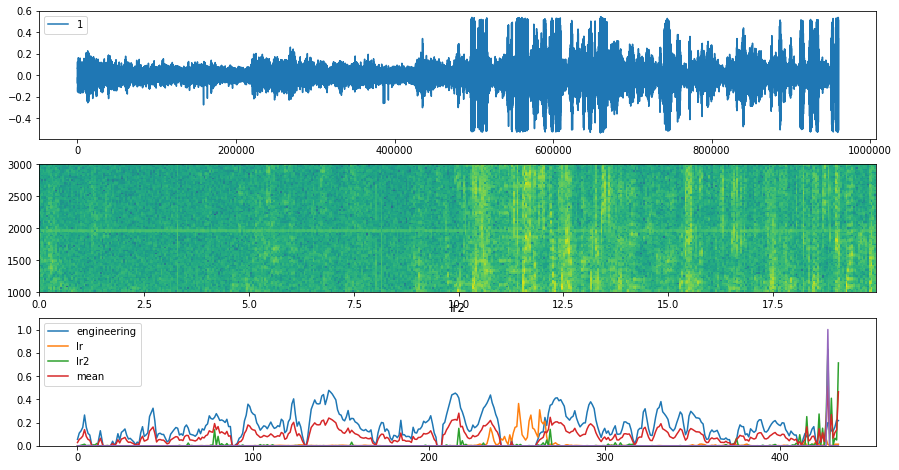

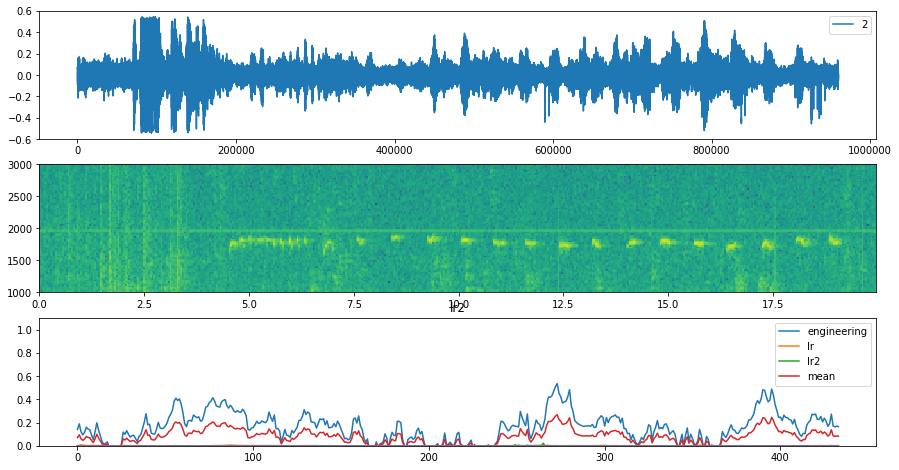

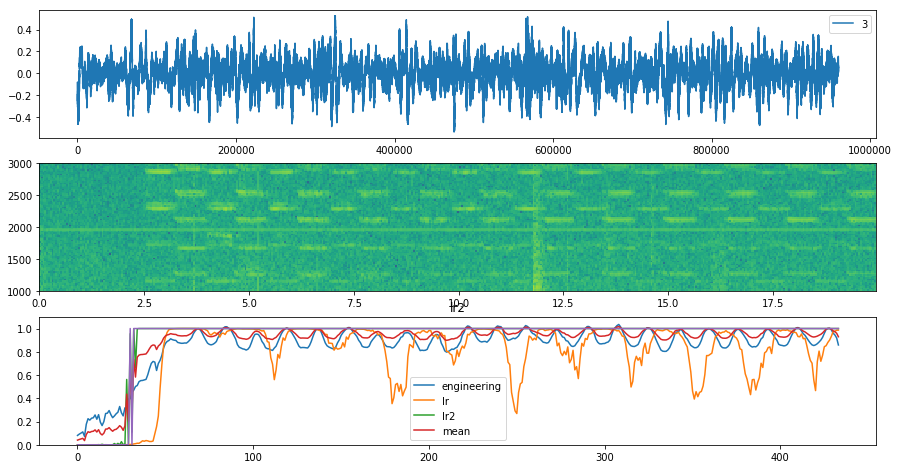

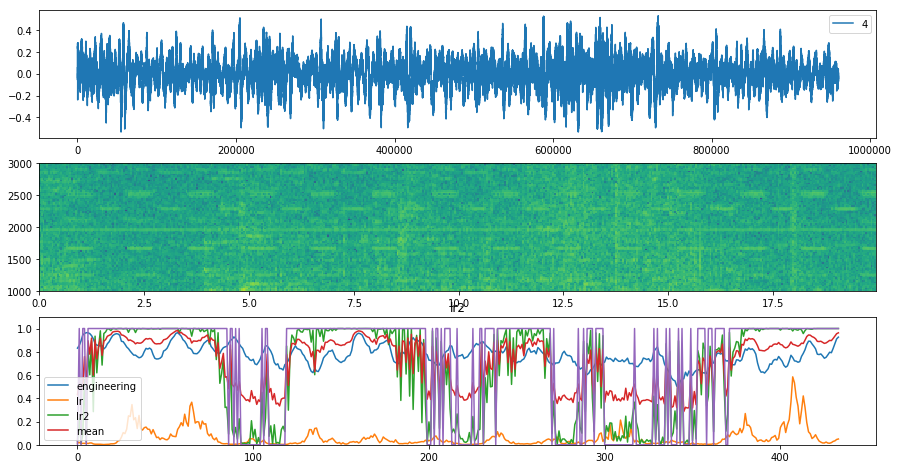

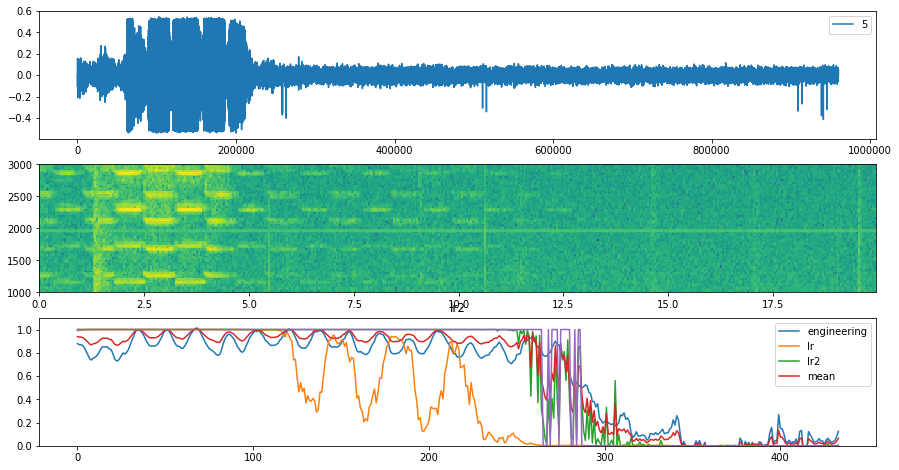

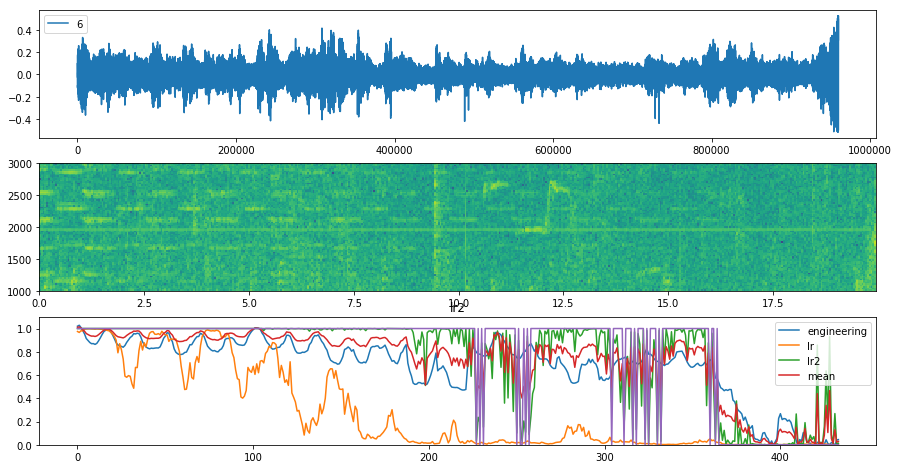

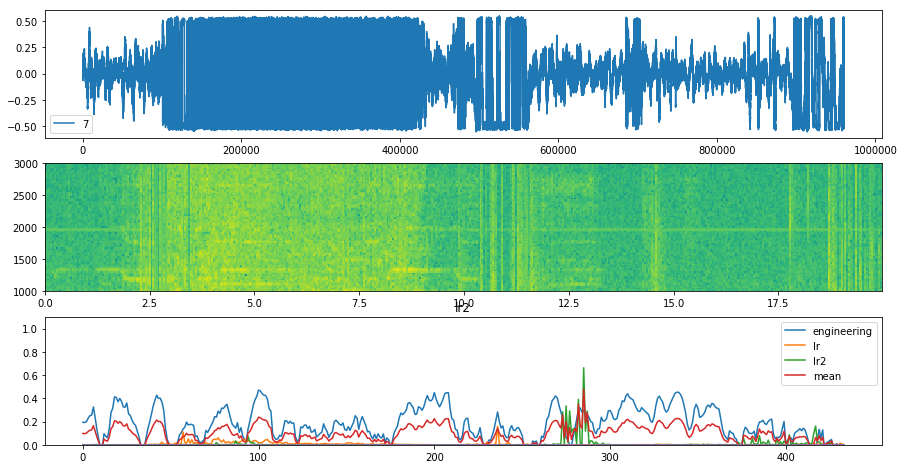

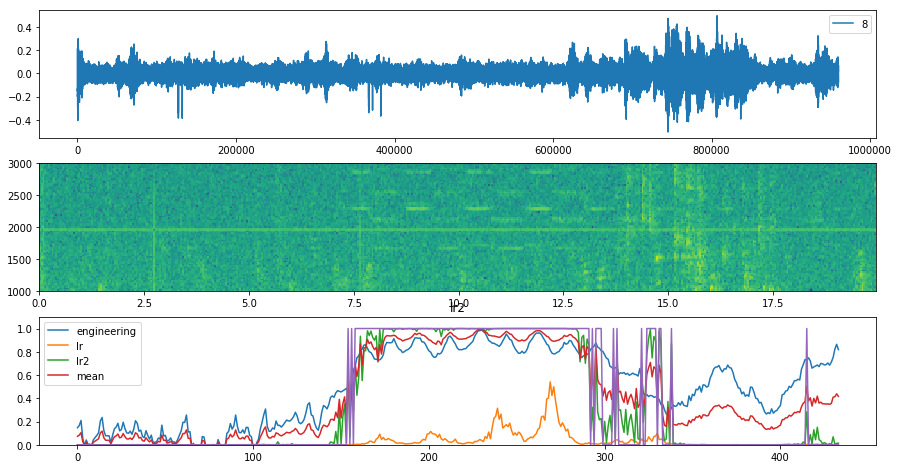

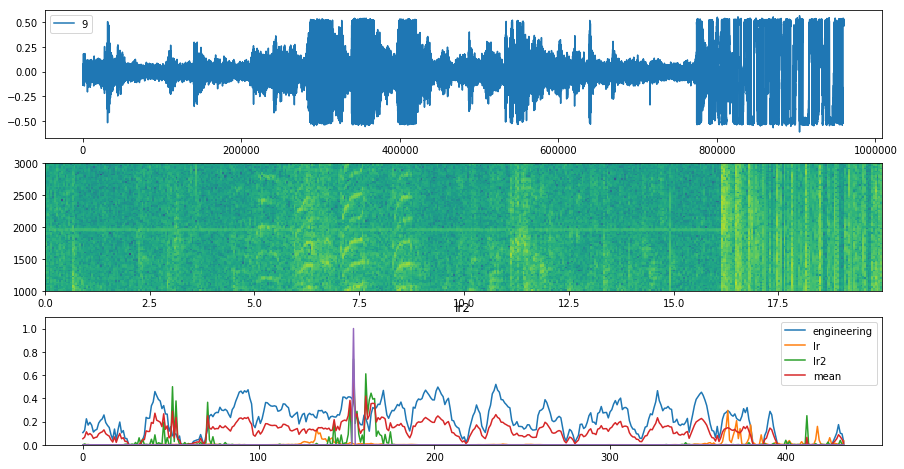

In [25]:
for nr,sig in enumerate(sigs):
    plt.figure(figsize=(15,8))
    plt.subplot(3,1,1)
    plt.plot(sig)
    plt.legend(str(nr))
    plt.subplot(3,1,2)
    spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0);
    plt.ylim((1000,3000))

    prbs = {}
    prbs['engineering'] = []
    prbs['lr'] = []
    prbs['lr2'] = []

    # window over the signal:
    win_size=34 #datapoints
    freqidx = (freqs>1000)*(freqs<3000)
    for i in range(0,spectrum.shape[1]-win_size):
        spec = spectrum[:,i:i+win_size]

        a= np.log ( spec[[73, 96, 97, 98, 121, 122]] )
        a-=a.mean()
        a/=a.std()
        #plt.plot( a.T )
        b=np.log( np.roll(spec[[71, 88, 89, 90, 91, 123, 124]], 17,axis=1) )
        b-=b.mean()
        b/=b.std()
        #plt.plot( b.T )
        c=(a.sum(axis=0)+b.sum(axis=0))
        c-=c.mean()
        c/=c.std()
        #d = np.roll(c,17)-c
        #plt.plot(c.T)
        d = np.abs( np.convolve(c,[*(np.ones(8)-2),*np.ones(17),*(np.ones(8)-2)]) )
        d = (d)+np.roll(d,26) #make oscilation to permanent
        prbs['engineering'].append((d.sum()-300)/1000)

        X = (np.log(spec[freqidx])+15)/3 #scale
        X_lin = X.reshape(1,-1)
        prbs['lr'].append( clf.predict_proba(X_lin[:,:2890])[:,1] )
        prbs['lr2'].append( clf2.predict_proba(X_lin[:,:2890])[:,1] )
    
    plt.subplot(3,1,3)
    for ix, k in enumerate( prbs.keys() ):
        plt.plot( prbs[k])
        plt.ylim((0,1.1))
        plt.title(k)
    
    m = (np.asarray(prbs['engineering']).flatten()+np.asarray(prbs['lr2']).flatten())/2
    plt.plot(m.T)
    plt.legend([*prbs.keys(),'mean'])
    plt.plot(m>0.5)

In [5]:
sd.play(sigs[6])

In [202]:
spectrum.shape[1]

468

<IPython.core.display.Javascript object>


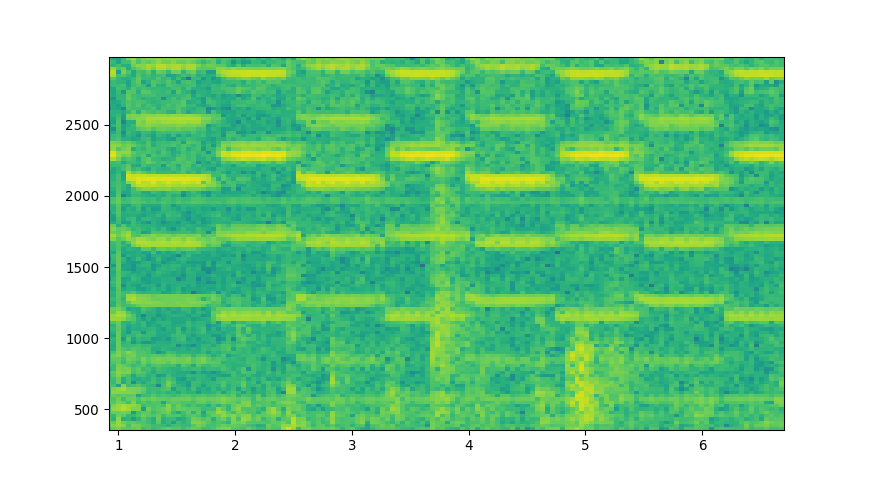

In [132]:
%matplotlib notebook
plt.figure(figsize=(9,5))
spectrum, freqs, t, im=specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0);

<IPython.core.display.Javascript object>


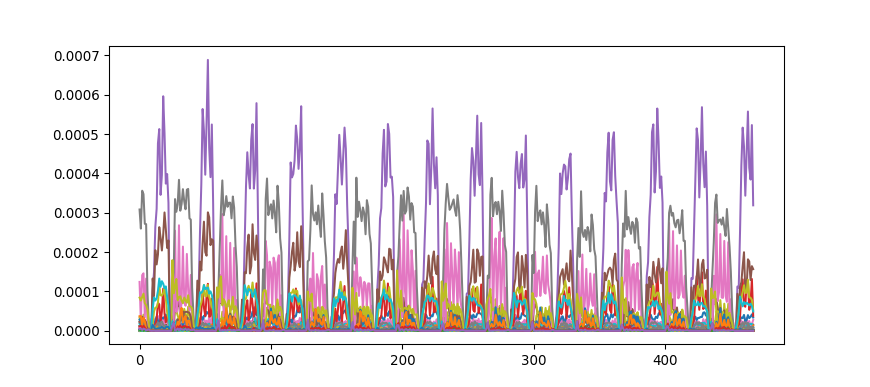

43

In [133]:
plt.figure(figsize=(9,4))
fidx = (freqs>1000) * (freqs<3000)
plt.plot(spectrum[fidx].T)
fidx.argmax() #91

<IPython.core.display.Javascript object>


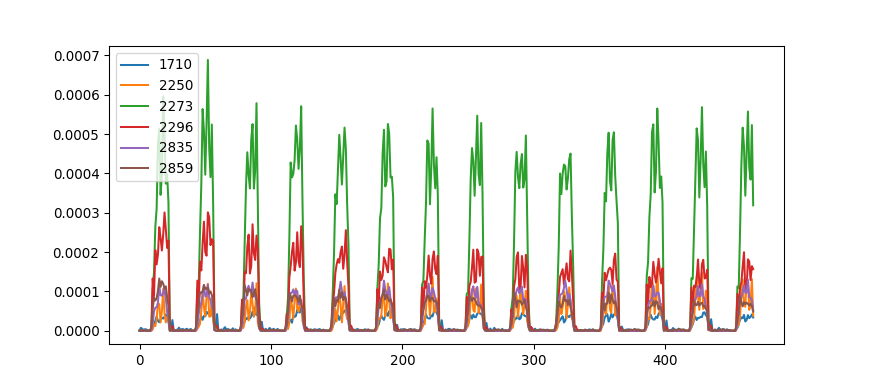

In [254]:
plt.figure(figsize=(9,4))

aa = (spectrum[fidx,52]>0.00004)>0 #.sum(axis=1)
plt.plot(spectrum[fidx][aa].T);
iFreqs = freqs[fidx][aa].astype(int)
plt.legend(iFreqs)

f1 = [1664, 2062, 2085, 2109, 2132, 2882, 2906]
f2 = [1710, 2250, 2273, 2296, 2835, 2859]
iFreqs=[*f1,*f2]

In [258]:
iFreqIdx = []
for iff in iFreqs:
    iff*=100
    iFreqIdx.append( (freqs.astype(int)*100==iff).argmax() )
iFreqIdx

[71, 88, 89, 90, 91, 123, 124, 73, 96, 97, 98, 121, 122]

<IPython.core.display.Javascript object>


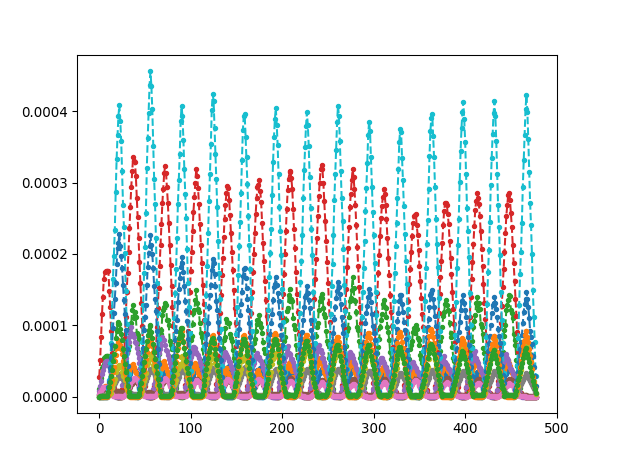

In [256]:
#plt.plot( np.diff(,n=1).T )
for n in range(len(iFreqIdx)):
    filtered = np.convolve( spectrum[iFreqIdx[n]],np.ones(11)/11)
    plt.plot(filtered,'.--')

<IPython.core.display.Javascript object>


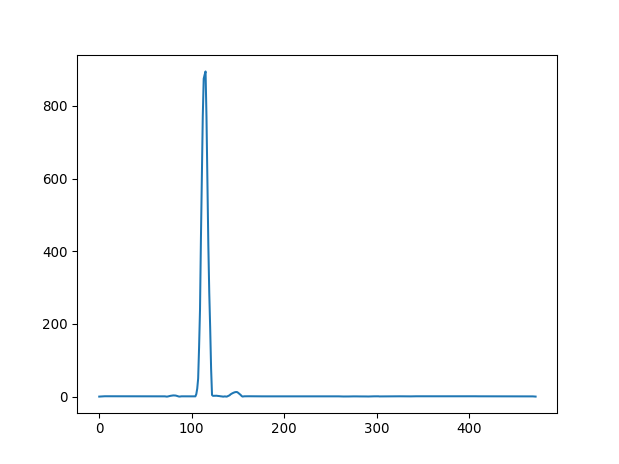

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [336]:
plt.figure()
a= spectrum[[73, 96, 97, 98, 121, 122]]
a-=a.mean()
a/=a.std()
#plt.plot( a.T )
b=np.roll(spectrum[[71, 88, 89, 90, 91, 123, 124]], 17,axis=1)
b-=b.mean()
b/=b.std()
#plt.plot( b.T )
c=(a.sum(axis=0)*b.sum(axis=0))
#plt.plot(c.T)
d = np.abs(np.convolve(c,np.ones(6)/6))
plt.plot( d )
(d>(1*10**-6))

<IPython.core.display.Javascript object>


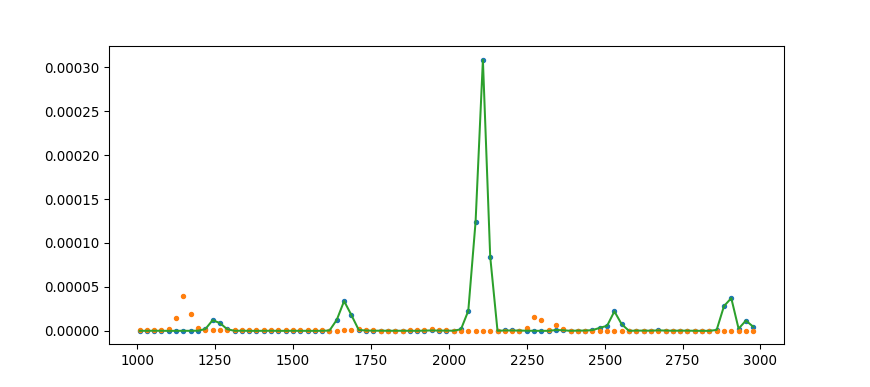

In [253]:
plt.figure(figsize=(9,4))

fidx = (freqs>1000) * (freqs<3000)#(f.astype(int)==).argmax()

ts = [102,100]
idxs=[]
for tt in ts:
    idxs.append( (t.astype(int)*100==tt).argmax())

plt.plot(freqs[fidx],spectrum[fidx][:,idxs],'.')

idxs=[]
ts = [125]
for tt in ts:
    idxs.append( (t.astype(int)*100==tt).argmax() )

plt.plot(freqs[fidx],spectrum[fidx][:,idxs])

#plt.yscale('log')

In [ ]:
freqs = []

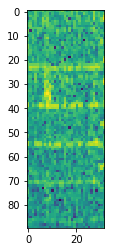

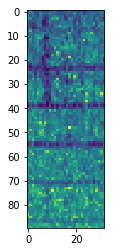

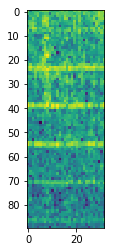

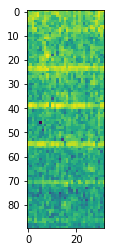

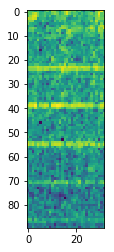

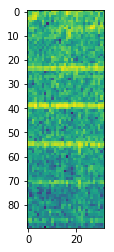

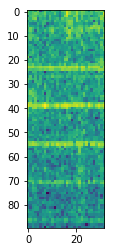

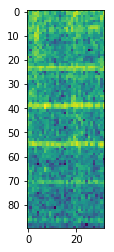

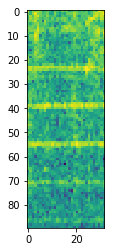

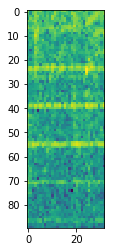

In [30]:
%matplotlib inline
# record something
duration = 1.4 #1.45  # seconds

buff_len=3
spectra=np.ones((buff_len, 90, 32))

for n in range(10):
    sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(duration)
    plt.figure()
    spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    plt.close()
    
    plt.figure()
    spectra[n%buff_len]=np.log(spectrum[40:130])
    plt.imshow(spectra.prod(axis=0))
    plt.show()

In [5]:
def mySpec(sig):
    nfft = 1024
    l = range(0,len(sig)-len(sig)%nfft,nfft)
    a = np.zeros((nfft//2,len(l)))
    #sig = sig-sig.mean()
    for si, s in enumerate(l):
        ss = sig[s:s+nfft].flatten()
        a[:,si] = (np.abs(np.fft.fft(ss)).flatten()/nfft)[:nfft//2] #flatten!!! otherwise it will be done over rows =SSSS
        # fuck that cost me some time =S
    return a
    #plt.imshow((np.log(a)))

<IPython.core.display.Javascript object>


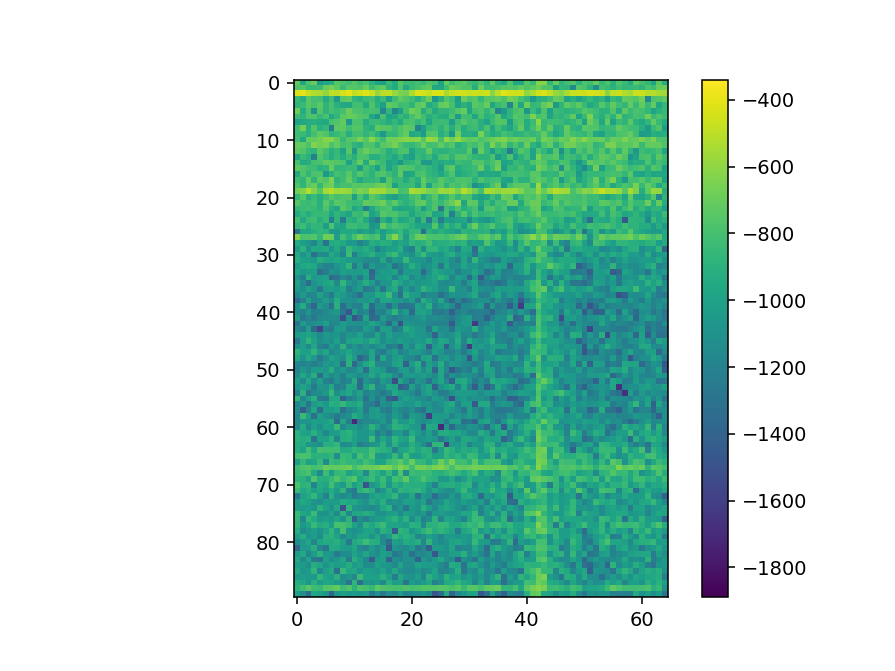

In [13]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# record something
duration = 1.4 #1.45  # seconds
buff_len=3

#spectra=np.ones((buff_len, 90, 65))

fig = plt.figure()
img = plt.imshow(spectra.prod(axis=0))
plt.colorbar()

def getSpectrum(sig):
    spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    return spectrum, freqs, t, im

def animate(n):
    sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(duration)
    spectrum = mySpec(sig)
    #spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    spectra[n%buff_len]=np.log(spectrum[40:130])
    img.set_data(spectra.prod(axis=0))
    return img

anim = animation.FuncAnimation(fig, animate, frames=100, repeat=True)

In [ ]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# record something
duration = 1.4 #1.45  # seconds
buff_len=3

#spectra=np.ones((buff_len, 90, 65))

fig = plt.figure()
img = plt.imshow(spectra.prod(axis=0))
plt.colorbar()

def getSpectrum(sig):
    spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    return spectrum, freqs, t, im

for n in range(10):
    sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(duration)
    spectrum = mySpec(sig)
    #spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    spectra[n%buff_len]=np.log(spectrum[40:130])
    img.set_data(spectra.prod(axis=0))
    img.show()


<Figure size 432x288 with 0 Axes>

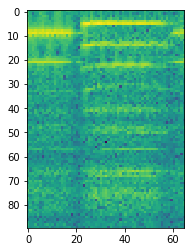

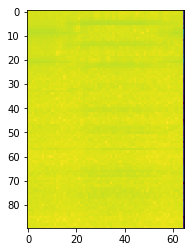

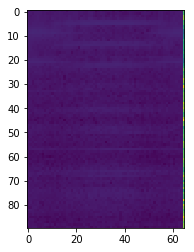

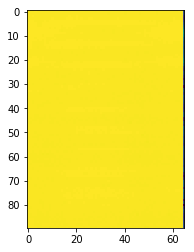

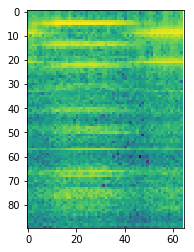

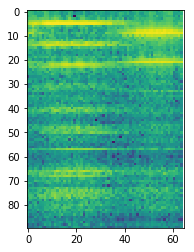

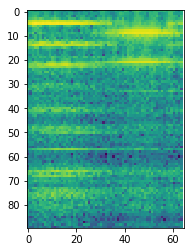

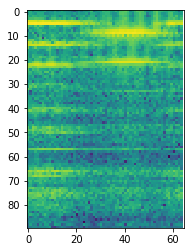

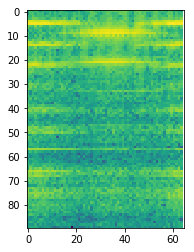

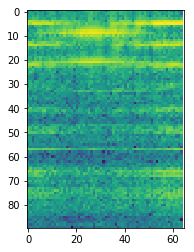

In [17]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# record something
duration = 1.4 #1.45  # seconds
buff_len=3

spectra=np.ones((buff_len, 90, 65))

plt.figure()
plt.show()

for n in range(10):
    sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(duration)
    spectrum = mySpec(sig)
    spectra[n%buff_len]=np.log(spectrum[40:130])
    plt.imshow(spectra.prod(axis=0))
    plt.show()

<IPython.core.display.Javascript object>


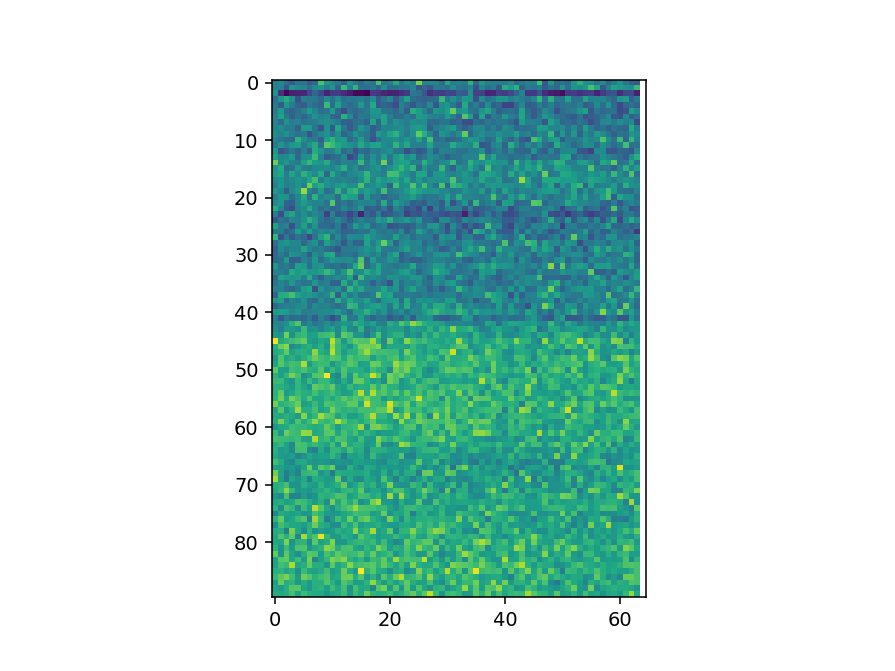

In [17]:
n=1
sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
time.sleep(duration)
spectrum = mySpec(sig)
spectra[n%buff_len]=np.log(spectrum[40:130])
plt.imshow(np.log(spectra.prod(axis=0)))

<IPython.core.display.Javascript object>


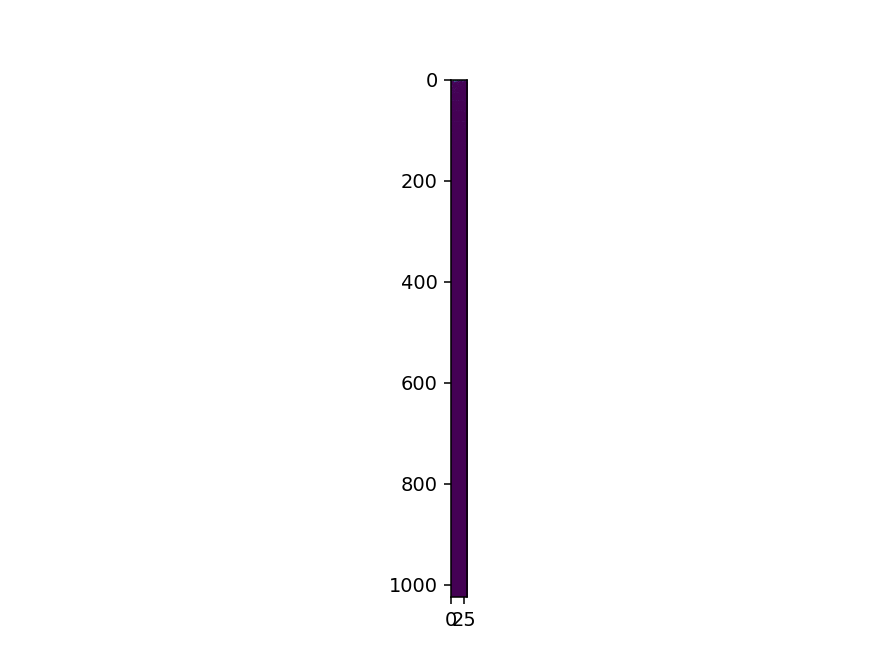

In [14]:
plt.figure()
for n in range(10):
    sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(duration)
    #freqs, t, spectrum = signal.spectrogram(samples, sample_rate)
    spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
    spectra[n%buff_len]=np.log(spectrum[40:130])

E:\Portable-Apps\PortableApps\Anaconda\lib\site-packages\scipy\signal\spectral.py:1785: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  .format(nperseg, input_length))


[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


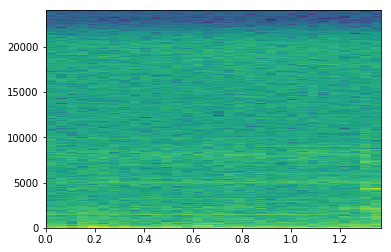

In [37]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate = 44*10**3
sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
time.sleep(duration)

spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
frequencies, times, spectrogram = signal.spectrogram(sig, fs=fs,noverlap=0,nfft=1024)
print(spectrogram)

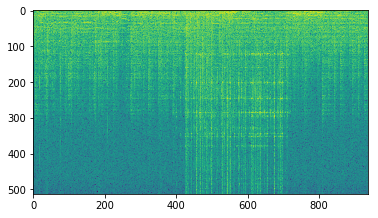

In [104]:
spectrum, freqs, t, im =specgram(sig.flatten(),Fs=fs,NFFT=1024,scale='dB',noverlap=0,mode='magnitude' );
plt.imshow(np.log(spectrum))

In [15]:
np.asarray(spectra).shape

(4, 1025, 33)

In [53]:
import glob
fns = glob.glob("*.npy")
sigs = []
ys = []
for fn in fns:
    sigs.append( np.load(fn) )
    ys.append(fn.split('_')[3])

In [4]:
# play the sound
sd.play(sig, fs)

(0, 5000)

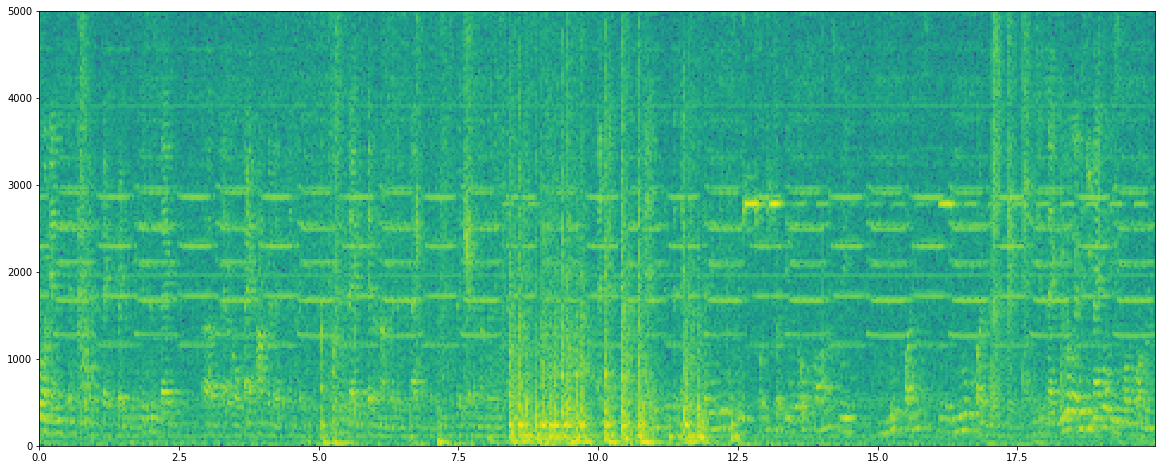

In [29]:
sig = sigs[1]
plt.figure(figsize=(20,8))
spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=2**11,scale='dB',noverlap=0)
plt.ylim(0, 5000)

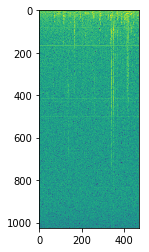

In [11]:
plt.imshow(np.log(spectrum))

In [12]:
f = np.fft.fft2(np.log(spectrum))

<IPython.core.display.Javascript object>


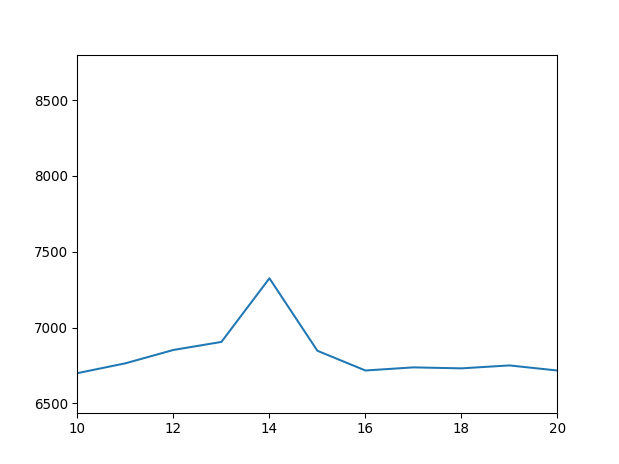

In [108]:
plt.figure()
plt.plot(np.log(np.abs(f)).sum(axis=0))
plt.xlim((10,20))
plt.show()

In [7]:

sd.play(myrecording, fs)

<IPython.core.display.Javascript object>


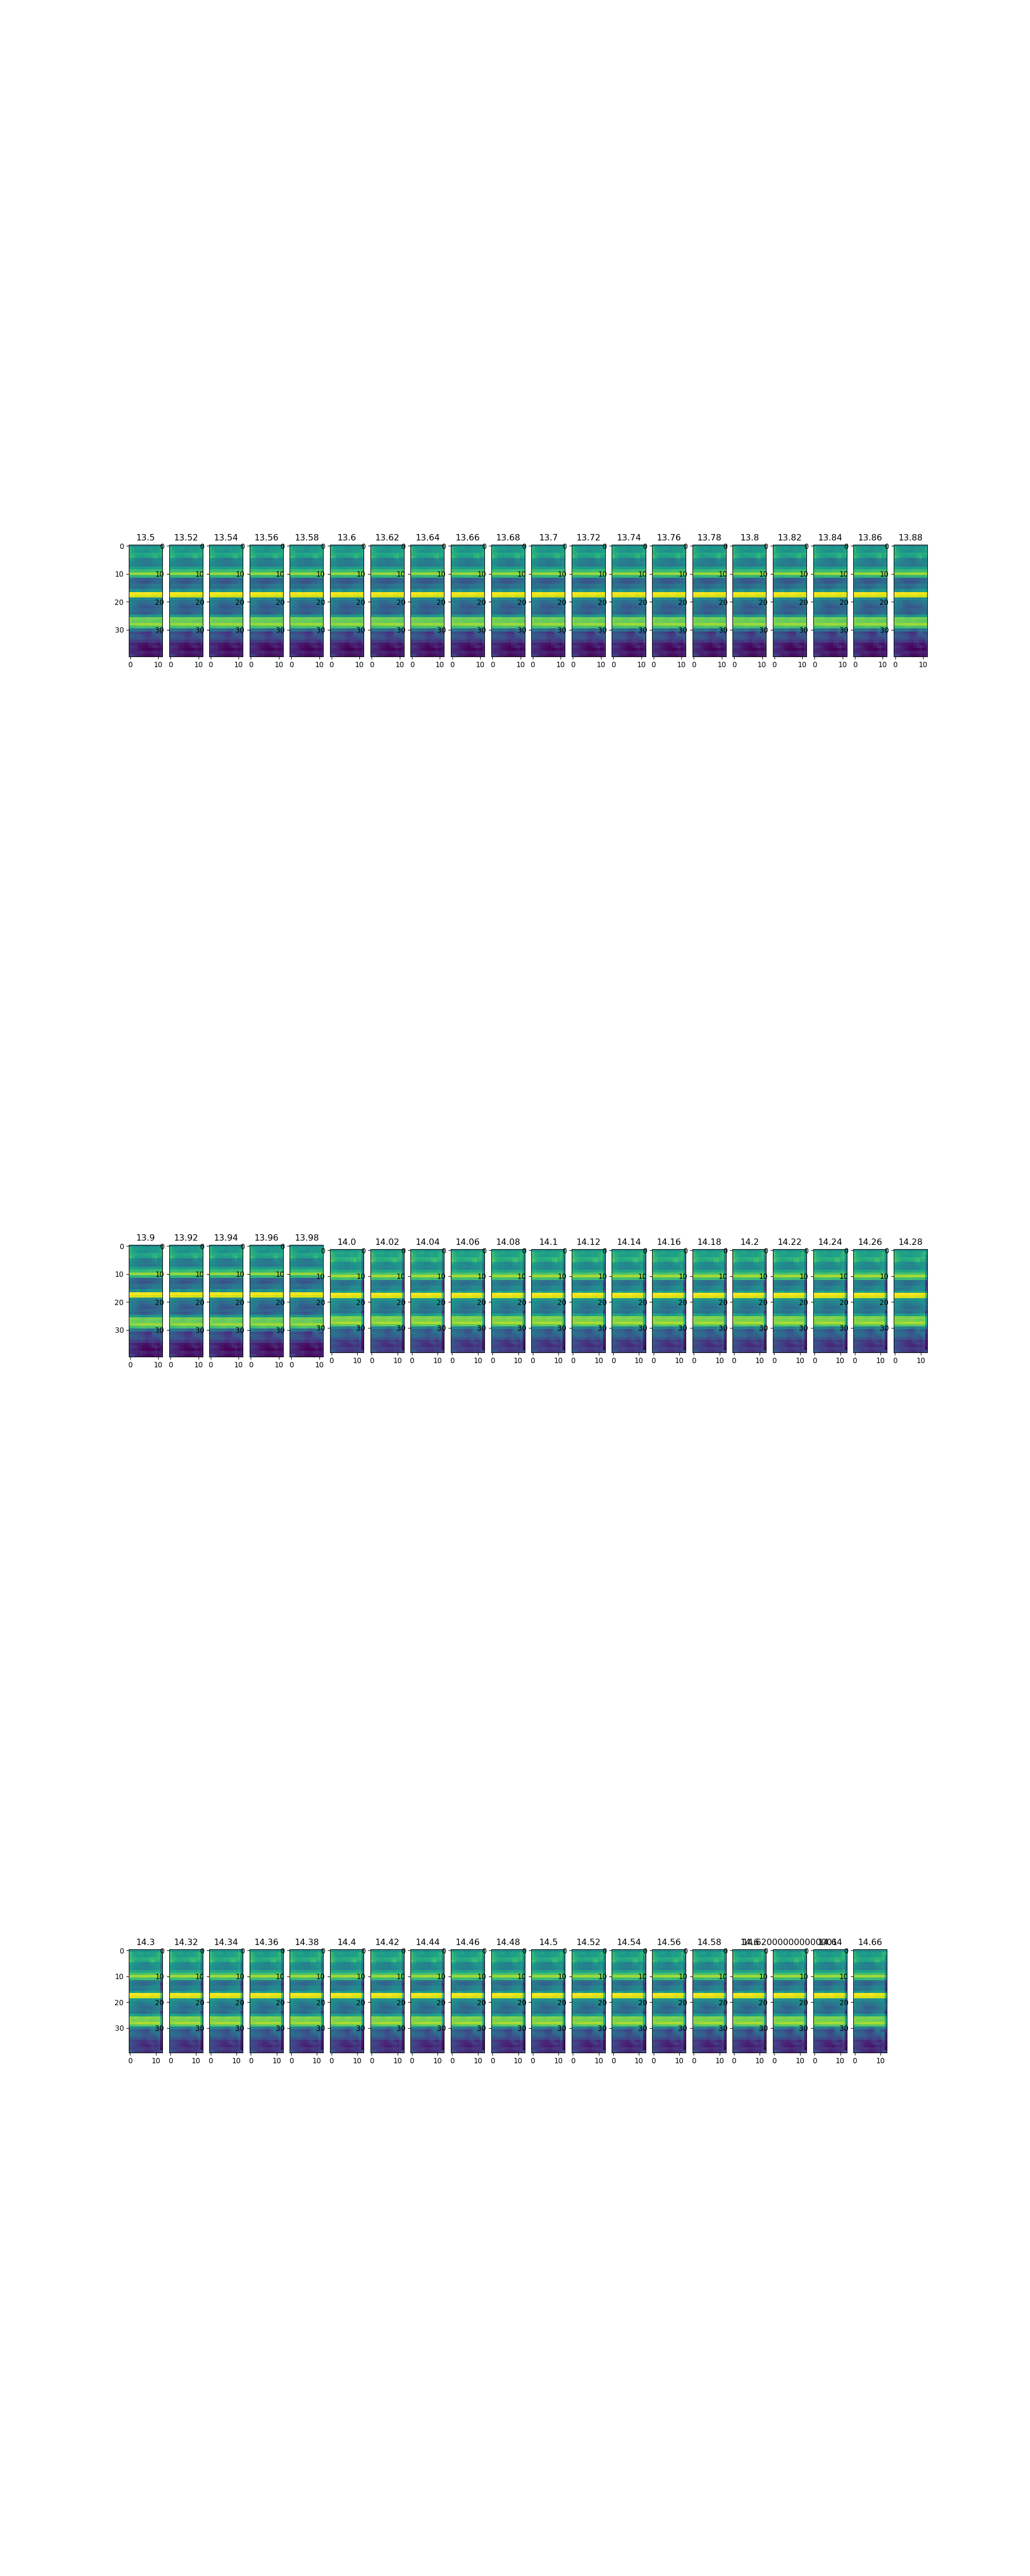

In [168]:
h = spectrum.shape[0]
b = spectrum.shape[1]
offset=130
plt.figure(figsize=(20,50))

for j in range(59):
    stepsize = 13.5+0.02*j
    acu = spectrum[:,offset + 0:offset+int(stepsize-1)]
    for i in range(1, 10): #(b//stepsize)
        acu += spectrum[:,offset + int(i*stepsize):offset+int((i*stepsize)+int(stepsize-1))]

    plt.subplot(3,20,j+1)
    plt.imshow(np.log(acu[80:120,:]))
    plt.title(str(stepsize))

In [139]:
int(np.floor(12.2))

12

In [101]:
stepsize = 14
for i in range(1,10):
    print(b//stepsize)

33
33
33
33
33
33
33
33
33


In [ ]:
import sounddevice as sd
import time
import matplotlib.pyplot as plt
import numpy as np
from pylab import *

#Parameters--------------
fs = 48*10**3 #48k
nfft = 2**11
buff_len = 1
duration = 1.46
f_min = 1000
f_max = 3000

scaling_mean = -15
scaling_std = 3

#------------------------
sd.default.samplerate = fs
sd.default.channels = 1

# load the clf
from sklearn.externals import joblib
clf = joblib.load('alarm_lr_clf2.pkl')

def computeEngineeringSol(spec):
    """
        Compute the engineering solution given the spectrogram for 1.5 seconds
    """
    a= np.log ( spec[[73, 96, 97, 98, 121, 122]] )
    a-=a.mean()
    a/=a.std()

    b=np.log( np.roll(spec[[71, 88, 89, 90, 91, 123, 124]], 17,axis=1) )
    b-=b.mean()
    b/=b.std()

    c=(a.sum(axis=0)+b.sum(axis=0))
    c-=c.mean()
    c/=c.std()

    d = np.abs( np.convolve(c,[*(np.ones(8)-2),*np.ones(17),*(np.ones(8)-2)]) )
    d = (d)+np.roll(d,26) #make oscilation to per
    return (d.sum()-300)/1000

def mySpec(sig,fs,nfft):
    l = range(0,len(sig)-len(sig)%nfft,nfft)
    a = np.zeros((nfft//2,len(l)))
    #sig = sig-sig.mean()
    for si, s in enumerate(l):
        ss = sig[s:s+nfft].flatten()
        a[:,si] = (np.abs(np.fft.fft(ss))/nfft)[:nfft//2] #flatten!!! otherwise it will be done over rows =SSSS
        # fuck that cost me some time =S
    freqs = np.linspace(0,fs/2,(nfft/2))
    t = np.linspace(0,(len(sig)-len(sig)%nfft)/fs,len(l))
    return a, freqs, t
    #plt.imshow((np.log(a)))

while True:
    #record
    sig = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    time.sleep(duration)
    
    #compute spectrogram
    
    #spectrum, freqs, t, im = specgram(sig.flatten(),Fs=fs,NFFT=nfft,scale='dB',noverlap=0)
    spectrum, freqs, t = mySpec(sig.flatten(),fs,nfft)
    
    freqidx = (freqs>f_min)*(freqs<f_max)
    X = (np.log(spectrum[freqidx])+scaling_mean)/scaling_std #scale
    
    #spectrum = mySpec(sig)
    #X = np.log(spectrum[43:128])
    #X-=X.mean()
    #X/=X.std()
    #X = ()#+16.7)/2.25
    
    #plt.imshow(X)
    
    X=np.nan_to_num(X) #make sure there are no nan's in there
    prob = clf.predict_proba(X.reshape(1,-1)[:,:2890])[:,1]
    
    # engineering solution:
    prob2 = computeEngineeringSol(spectrum)
    
    fin = (prob+prob2)
    
    print('lr: {:4.0f}% engineeringSol: {:4.0f} finDecision: {}'.format(prob[0]*100, prob2*100,fin>0.5), end='\n')

/home/aadc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


lr:   40% engineeringSol:   56 finDecision: [ True]
lr:   99% engineeringSol:   81 finDecision: [ True]
lr:   98% engineeringSol:   76 finDecision: [ True]
lr:   79% engineeringSol:   75 finDecision: [ True]
lr:   83% engineeringSol:   53 finDecision: [ True]
lr:    4% engineeringSol:   41 finDecision: [False]
lr:   22% engineeringSol:   49 finDecision: [ True]
lr:   49% engineeringSol:   52 finDecision: [ True]
lr:   17% engineeringSol:   59 finDecision: [ True]
lr:   21% engineeringSol:   53 finDecision: [ True]
lr:   25% engineeringSol:   59 finDecision: [ True]
lr:    0% engineeringSol:   44 finDecision: [False]
lr:    1% engineeringSol:    4 finDecision: [False]
lr:    5% engineeringSol:    5 finDecision: [False]
lr:    0% engineeringSol:   30 finDecision: [False]
lr:    0% engineeringSol:    7 finDecision: [False]
lr:    0% engineeringSol:   13 finDecision: [False]
lr:    0% engineeringSol:   20 finDecision: [False]
lr:    0% engineeringSol:   33 finDecision: [False]
lr:    1% en

lr:    0% engineeringSol:   10 finDecision: [False]
lr:    0% engineeringSol:   35 finDecision: [False]
lr:    0% engineeringSol:   26 finDecision: [False]
lr:    0% engineeringSol:   18 finDecision: [False]
lr:    0% engineeringSol:   38 finDecision: [False]
lr:    0% engineeringSol:   15 finDecision: [False]
lr:    0% engineeringSol:   32 finDecision: [False]
lr:    3% engineeringSol:    5 finDecision: [False]
lr:    1% engineeringSol:   12 finDecision: [False]
lr:    2% engineeringSol:   16 finDecision: [False]
lr:   34% engineeringSol:   43 finDecision: [ True]
lr:    1% engineeringSol:    8 finDecision: [False]
lr:    0% engineeringSol:   28 finDecision: [False]
lr:    0% engineeringSol:    8 finDecision: [False]
lr:    0% engineeringSol:   29 finDecision: [False]
lr:   35% engineeringSol:   14 finDecision: [False]
lr:    2% engineeringSol:   36 finDecision: [False]
lr:    1% engineeringSol:   41 finDecision: [False]
lr:    2% engineeringSol:   22 finDecision: [False]
lr:    0% en

lr:   19% engineeringSol:   34 finDecision: [ True]
lr:    0% engineeringSol:   10 finDecision: [False]
lr:    1% engineeringSol:   11 finDecision: [False]
lr:    0% engineeringSol:   37 finDecision: [False]
lr:    0% engineeringSol:   14 finDecision: [False]
lr:    0% engineeringSol:   26 finDecision: [False]
lr:    1% engineeringSol:    8 finDecision: [False]
lr:    1% engineeringSol:   32 finDecision: [False]
lr:    0% engineeringSol:   27 finDecision: [False]
lr:    4% engineeringSol:   24 finDecision: [False]
lr:    0% engineeringSol:   29 finDecision: [False]
lr:    0% engineeringSol:    7 finDecision: [False]
lr:    2% engineeringSol:   29 finDecision: [False]
lr:    0% engineeringSol:    7 finDecision: [False]
lr:    0% engineeringSol:   26 finDecision: [False]
lr:    0% engineeringSol:   20 finDecision: [False]
lr:    0% engineeringSol:   13 finDecision: [False]
lr:    0% engineeringSol:   14 finDecision: [False]
lr:    1% engineeringSol:   13 finDecision: [False]
lr:    0% en

lr:    0% engineeringSol:   -0 finDecision: [False]
lr:    3% engineeringSol:   28 finDecision: [False]
lr:    1% engineeringSol:   30 finDecision: [False]
lr:    0% engineeringSol:   17 finDecision: [False]
lr:    0% engineeringSol:   24 finDecision: [False]
lr:    1% engineeringSol:   31 finDecision: [False]
lr:    0% engineeringSol:   35 finDecision: [False]
lr:    1% engineeringSol:   21 finDecision: [False]
lr:    1% engineeringSol:   21 finDecision: [False]
lr:    6% engineeringSol:    5 finDecision: [False]
lr:    1% engineeringSol:   36 finDecision: [False]
lr:    0% engineeringSol:   -5 finDecision: [False]
lr:    0% engineeringSol:   29 finDecision: [False]
lr:    1% engineeringSol:    3 finDecision: [False]
lr:    0% engineeringSol:   14 finDecision: [False]
lr:    4% engineeringSol:    5 finDecision: [False]
lr:    0% engineeringSol:    4 finDecision: [False]
lr:    0% engineeringSol:   27 finDecision: [False]
lr:    1% engineeringSol:   27 finDecision: [False]
lr:    0% en

lr:    0% engineeringSol:   44 finDecision: [False]
lr:    0% engineeringSol:   13 finDecision: [False]
lr:    0% engineeringSol:   14 finDecision: [False]
lr:    0% engineeringSol:   21 finDecision: [False]
lr:    0% engineeringSol:   12 finDecision: [False]
lr:    0% engineeringSol:   27 finDecision: [False]
lr:    5% engineeringSol:   41 finDecision: [False]
lr:    0% engineeringSol:   24 finDecision: [False]
lr:    0% engineeringSol:   34 finDecision: [False]
lr:    1% engineeringSol:   23 finDecision: [False]
lr:    1% engineeringSol:   47 finDecision: [False]
lr:    0% engineeringSol:   36 finDecision: [False]
lr:    1% engineeringSol:   20 finDecision: [False]
lr:    4% engineeringSol:   31 finDecision: [False]
lr:    1% engineeringSol:   24 finDecision: [False]
lr:    0% engineeringSol:   40 finDecision: [False]
lr:    1% engineeringSol:   19 finDecision: [False]
lr:    0% engineeringSol:   41 finDecision: [False]
lr:    1% engineeringSol:    3 finDecision: [False]
lr:    0% en

In [297]:
(prob[0]*100, prob2)

(0.0002421913704073014, 0.1127863831076942)